### TWEET EMOTION RECOGNITION: NLP WITH TENSORFLOW
---

### Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

/home/fernandofincatti/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
from src.functions.show import show_history, show_confusion_matrix
from src.functions.tweet import get_tweet, get_sequences, label_to_number

### Import data

In [3]:
dataset = nlp.load_dataset("emotion") #install data

Using custom data configuration default


In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

### Split dataset

In [5]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [6]:
print("Number of examples in train: {0}".format(len(train)))
print("Number of examples in validation: {0}".format(len(val)))
print("Number of examples in test: {0}".format(len(test)))

Number of examples in train: 16000
Number of examples in validation: 2000
Number of examples in test: 2000


###

### Tweets

In [7]:
tweets, labels = get_tweet(train)
print("Tweet: {0}\nLabel: {1}".format(tweets[0], labels[0]))

Tweet: i didnt feel humiliated
Label: sadness


### Tokenizer


In [8]:
# uses the tokenizer for the most common 10.000 words
# if an word isn't present on the most common, the corresponding token is <UNK>
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [9]:
example_token = tokenizer.texts_to_sequences([tweets[0]])
print("Tweet: {0}\nToken: {1}".format(tweets[0], example_token))

Tweet: i didnt feel humiliated
Token: [[2, 139, 3, 679]]


### Padding and truncating sequences

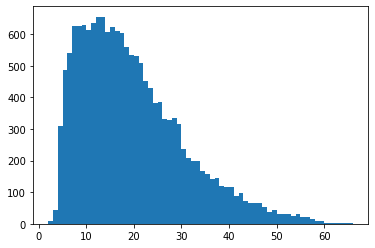

In [10]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=(len(set(lengths))))
plt.show()

In [11]:
train_seq_padded = get_sequences(tokenizer, tweets, maxlen=50)

In [12]:
train_seq_padded[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing the labels

In [13]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

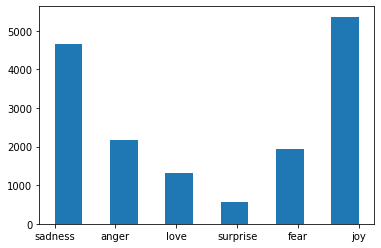

In [14]:
plt.hist(labels, bins=11)
plt.show()

In [15]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_classes = dict((v,k) for k, v in class_to_index.items())

In [16]:
class_to_index

{'joy': 0, 'sadness': 1, 'love': 2, 'fear': 3, 'anger': 4, 'surprise': 5}

In [17]:
index_to_classes

{0: 'joy', 1: 'sadness', 2: 'love', 3: 'fear', 4: 'anger', 5: 'surprise'}

In [18]:
train_labels = label_to_number(labels, class_to_index)

### Creating the model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Training model

In [26]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = label_to_number(val_labels, class_to_index)

In [29]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [31]:
h = model.fit(
    train_seq_padded, 
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
    ]
)

Epoch 1/20


2022-08-08 16:33:48.222300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


500/500 [==============================] - 8s 8ms/step - loss: 1.3350 - accuracy: 0.4823 - val_loss: 0.9839 - val_accuracy: 0.6245
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.6950 - accuracy: 0.7324 - val_loss: 0.6307 - val_accuracy: 0.7865
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3684 - accuracy: 0.8786 - val_loss: 0.4365 - val_accuracy: 0.8565
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.2292 - accuracy: 0.9277 - val_loss: 0.4039 - val_accuracy: 0.8670
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1626 - accuracy: 0.9504 - val_loss: 0.4303 - val_accuracy: 0.8695
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1294 - accuracy: 0.9596 - val_loss: 0.3936 - val_accuracy: 0.8745
Epoch 7/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1073 - accuracy: 0.9667 - val_loss: 0.4502 - val_accuracy: 0.8700
Epoch 8/20
500/50